# Candidate features

## App usage
- Current: None
- Window:
    - Mean/Std./DWT of Usage duration per app category
    - Usage frequency per app category
    - App switching frequency

## Battery
- Current:
    - Level
    - Temperature
    - Plugged or not
- Window:
    - Mean/Std./DWT of pluggin and unplugging duration
    - Mean/Std./DWT for temperature
    - Mean/Std./DWT for level
    - Frequency of plugging and unplugging

## Call log
- Current:
    - Calling or not
- Window:
    - Mean/Std./DWT of call duration with people within/without contact
    - Call frequency with people within/without contact
    - Missed call frequency

## Connectivity
- Current:
    - Type of connection
- Window:
    - Mean/Std./DWT of duration per connection type
    - Frequency per connection type

## Data traffic
- Current: None
- Window:
    - Mean/Std./DWT of Rx
    - Mean/Std./DWT of Tx

## Screen
- Current:
    - Screen state
- Window:
    - Mean/Std./DWT of duration per screen state

## Ringer mode
- Current:
    - Ringer mode
- Window:
    - Mean/Std./DWT of duration per ringer mode

## Location
- Current:
    - Label of location
- Window:
    - Mean/Std./DWT of styaing duration per clustered location

## Message
- Current: None
- Window:
    - Frequency of sent messages within/without contacts
    - Frequency of received messages within/without contacts

## Notification
- Current: None
- Window:
    - Frequency of received notification per app category

## Activity
- Current:
    - Activity types
- Window:
    - Mean/Std./DWT of duration per activity types
    - Frequency of activities

# Settings

## Load Extensions

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext sql
%sql mysql+pymysql://iclab:iclabsystem12!@@143.248.90.87:3308/abc?charset=utf8

%config SqlMagic.feedback = False

## Load Ground-truth Data

In [2]:
import pandas as pd
import numpy as np

surveys = pd.read_excel('./Data/surveys.xlsx')
surveys.loc[:, 'is_perceived'] = np.where(
    surveys.loc[:, 'is_perceived'].values == 'Y', 1, 0
)
surveys.loc[:, 'is_available'] = np.where(
    (surveys.loc[:, 'is_perceived'].values == 1) & (surveys.loc[:, 'is_available'].values == 'Y'), 1, 0  
)
surveys.loc[:, 'is_break'] = np.where(
    (surveys.loc[:, 'is_perceived'].values == 1) & (surveys.loc[:, 'is_available'].values == 1) & (surveys.loc[:, 'is_break'].values == 'Y'), 1, 0    
)

subjects = surveys.groupby([
    'email', 'is_perceived', 'is_available', 'is_break'
]).count()['survey_id'].reset_index().loc[
    lambda x: (x['is_break'] == 1) & (x['survey_id'] >= 10), :
]['email']

TARGET_SURVEYS = surveys.loc[lambda x: x['email'].isin(subjects), :]
PARTICIPANTS = list(TARGET_SURVEYS.loc[:, 'email'].unique())

## Specify Windows

In [3]:
MIN_SECONDS = 60 
HOUR_SECONDS = MIN_SECONDS * 60

WINDOWS = [
    MIN_SECONDS * 5, HOUR_SECONDS, HOUR_SECONDS * 3, HOUR_SECONDS * 6, HOUR_SECONDS * 12, HOUR_SECONDS * 24
]

# Feature Generation

## Feature-Generating Function

In [4]:
import beactive as ba
from typing import Iterable

async def load_data(emails: Iterable[str]):
    feature_data = []
    
    for email in emails:
        works = []

        settings = [
            ('app_usage_event', ba.AppUsageProcessor(WINDOWS)),
            ('battery', ba.BatteryProcessor(WINDOWS)),
            ('call_log', ba.CallLogProcessor(WINDOWS)),
            ('connectivity', ba.ConnectivityProcessor(WINDOWS)),
            ('data_traffic', ba.DataTrafficProcessor(WINDOWS)),
            ('device_event', ba.ScreenProcessor(WINDOWS)),
            ('device_event', ba.RingerModeProcessor(WINDOWS)),
            ('location', ba.LocationProcessor(WINDOWS)),
            ('message', ba.MessageProcessor(WINDOWS)),
            ('notification', ba.NotificationProcessor(WINDOWS)),
            ('physical_activity_transition', ba.ActivityProcessor(WINDOWS)),
            ('', ba.TimeProcessor(WINDOWS))
        ]
        for table_name, data_processor in settings:
            if table_name:
                query = 'SELECT * FROM abc.{} WHERE email = \'{}\' ORDER BY timestamp ASC'.format(table_name, email)
                data = %sql $query
                data = data.DataFrame()
                
                if len(data.index) == 0:
                    continue
            else:
                data = pd.DataFrame()
                
            works.append((data, data_processor))
        
        class_label = TARGET_SURVEYS.loc[
            lambda x: x['email'] == email, ['delivered_time', 'is_perceived', 'is_available', 'is_break']
        ]
        
        feature_data.append(await ba.process_data(email, works, class_label, 'delivered_time'))
        
    
    return feature_data

## Feature Generation

In [ ]:
DATA_SET = await load_data(PARTICIPANTS)

for data in DATA_SET:
    data.dump('./Feature')

## (Optional) Load Data from Disk

In [5]:
import os

DATA_SET = [
    ba.ProcessedData.load(os.path.join('./Feature', participant))
    for participant in os.listdir('./Feature')
]

# Classification

## Model Building Criteria
* Each survey datum has three binary labels: **Perception**, **Availability**, **Adherence**.
* Each label is only available when its directly-upper label is true (or, 1).
* Combination of labels can generate four of new labels

|Perception|Availability|Adherence|Label|Bit Presentation|
|-----|-----|-----|-----|---|
|0|X|X|Miss|000|
|1|0|X|Unavailable|100|
|1|1|0|Rejection|110|
|1|1|1|Acceptance|111|

### Case 1: Hierarchical model
* It has explicitly three binary classification models, where each model works only when its directly-upper model classfies datum into 1.
* Training data for each model
    * Perception: 000 vs. 100, 110, 111
    * Availability: 100 vs. 110, 111
    * Adherence: 111 vs. 110
* Final prediction should be made by combining each model's prediction result .

### Case 2: Combination of independent models
* It has three binary classification models.
* Training data for each model
    * Perception: 000 vs. 100, 110, 111
    * Availability: 000, 100 vs. 110, 111
    * Adherence: 000, 100, 110 vs. 111
* Final prediction should be made by combining each model's prediction result .

### Case 3: Single model
* It has one model that classifies data into four labels: 000, 100, 110, and 111.

### Case 4: Multi-task model
* It has one model that classifies data into multi-label.
* Final prediction should be made by combining each model's prediction result.

## Candidate Algorithms

### For combined binary classification (Case 1 and Case 2):
* Ensemble: Random forest, gradient boost, extra trees (from sklearn.ensemble), XGBoost (from xgboost)
* Tree: Decision tree, extra tree (from sklearn.tree)
* Linear model: Ridge regression, logistic regression (from sklearn.linear_model)
* SVM: NuSVC, SVC, Linear SVC (from sklearn.svc)
* Neural network: Multi-layer perceptron (from sklearn.neural_network)

### For multi-class classification (Case 3):
* Ensemble: Random forest, extra Trees, gradient boost (from sklearn.ensemble), XGBoost (from xgboost)
* Tree: Decision tree, extra tree (from sklearn.tree)
* Linear model: Ridge regression, logistic regression (from sklearn.linear_model)
* SVM: NuSVC, SVC, Linear SVC (from sklearn.svc)

### For multi-task (or, multi-label) classification (Case 4):
* Ensemble: Random forest, extra trees (from sklearn.ensemble)
* Tree: Decision tree, extra tree (from sklearn.tree)
* Linear model: Ridge regression (from sklearn.linear_model)
* Neural network: Multi-layer perceptron (from sklearn.neural_network)

    
 

## Setting

### Importing Classifiers

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV, MultiTaskElasticNetCV, MultiTaskLassoCV
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

### Building Wrappers without Tuning

In [7]:
WRAPPERS_DUMMY = {
    'DUM-MF': ba.Wrapper(DummyClassifier('most_frequent')),
    'DUM-ST': ba.Wrapper(DummyClassifier('stratified'))
}

WRAPPERS_BINARY = {
    'RF': ba.Wrapper(RandomForestClassifier()),
    'GB': ba.Wrapper(GradientBoostingClassifier()),
    'XGB': ba.Wrapper(XGBClassifier()),
    'DT': ba.Wrapper(DecisionTreeClassifier()),
    'ET': ba.Wrapper(ExtraTreesClassifier()),
    'ETs': ba.Wrapper(ExtraTreeClassifier()),
    'RC': ba.Wrapper(RidgeClassifierCV()),
    'LR': ba.Wrapper(LogisticRegressionCV(max_iter=1000)),
    'NuSVC-RBF': ba.Wrapper(NuSVC(gamma='scale', kernel='rbf')),
    'SVC-RBF': ba.Wrapper(SVC(gamma='scale', kernel='rbf')),
    'NuSVC-POLY': ba.Wrapper(NuSVC(gamma='scale', kernel='poly')),
    'SVC-POLY': ba.Wrapper(SVC(gamma='scale', kernel='poly')),
    'NuSVC-SIG': ba.Wrapper(NuSVC(gamma='scale', kernel='sigmoid')),
    'SVC-SIG': ba.Wrapper(SVC(gamma='scale', kernel='sigmoid')),
    'LinSVC': ba.Wrapper(LinearSVC()),
    'MLP': ba.Wrapper(MLPClassifier())
}

WRAPPERS_MULTICLASS = {
    'RF': ba.Wrapper(RandomForestClassifier()),
    'GB': ba.Wrapper(GradientBoostingClassifier()),
    'XGB': ba.Wrapper(XGBClassifier()),
    'DT': ba.Wrapper(DecisionTreeClassifier()),
    'ET': ba.Wrapper(ExtraTreeClassifier()),
    'ETs': ba.Wrapper(ExtraTreesClassifier()),
    'RC': ba.Wrapper(RidgeClassifierCV()),
    'LR-MN': ba.Wrapper(LogisticRegressionCV(max_iter=1000, multi_class='multinomial')),
    'LR-OVR': ba.Wrapper(LogisticRegressionCV(max_iter=1000, multi_class='ovr')),
    'NuSVC-RBF': ba.Wrapper(NuSVC(gamma='scale', kernel='rbf')),
    'SVC-RBF': ba.Wrapper(SVC(gamma='scale', kernel='rbf')),
    'NuSVC-POLY': ba.Wrapper(NuSVC(gamma='scale', kernel='poly')),
    'SVC-POLY': ba.Wrapper(SVC(gamma='scale', kernel='poly')),
    'NuSVC-SIG': ba.Wrapper(NuSVC(gamma='scale', kernel='sigmoid')),
    'SVC-SIG': ba.Wrapper(SVC(gamma='scale', kernel='sigmoid')),
    'LinSVC-CS': ba.Wrapper(LinearSVC(multi_class='crammer_singer')),
    'LinSVC-OVR': ba.Wrapper(LinearSVC(multi_class='ovr')),
    'MLP': ba.Wrapper(MLPClassifier())
}

WRAPPERS_MULTILABEL = {
    'RF': ba.Wrapper(RandomForestClassifier()),
    'DT': ba.Wrapper(DecisionTreeClassifier()),
    'ET': ba.Wrapper(ExtraTreeClassifier()),
    'ETs': ba.Wrapper(ExtraTreesClassifier()),
    'RC': ba.Wrapper(RidgeClassifierCV()),
    'MLP': ba.Wrapper(MLPClassifier())
}

### Define Cross-Validation Function

In [8]:
from typing import Dict
import asyncio
import warnings
from concurrent.futures import Executor, ProcessPoolExecutor

async def cross_validate_models(executor: Executor, 
                                wrappers: Dict[str, ba.Wrapper], 
                                email: str,
                                mode: int,
                                train: np.ndarray, 
                                label: np.ndarray, 
                                categories):
    result = pd.DataFrame()
    model_type = ''
    
    if mode == 0:
        model_type = 'Hierarchical'
    elif mode == 1:
        model_type = 'Combined'
    elif mode == 2:
        model_type = 'Multiclass'
    else:
        model_type = 'Multilabel'
    
    loop = asyncio.get_event_loop()
    
    workers = [
        loop.run_in_executor(executor, 
                             ba.Model(wrapper, mode, categories).cross_validate,
                             train, label, 5, name, model_type
                            )
        for name, wrapper in wrappers.items()
    ]
    
    scores = await asyncio.gather(*workers, return_exceptions=True)
    
    scores = [
        score
        for score in scores if not isinstance(score, Exception)
    ]
    
    for score, (name, model_type) in scores:
        score_dict = {
            **{'name': name, 'model_type': model_type, 'email': email},
            **{field: getattr(score, field) for field in score._fields if not isinstance(getattr(score, field), np.ndarray)},
            **{'{}th_label_precision'.format(idx + 1): precision for idx, precision in enumerate(score.precision_each)},
            **{'{}th_label_recall'.format(idx + 1): recall for idx, recall in enumerate(score.recall_each)},
            **{'{}th_label_f1'.format(idx + 1): f1 for idx, f1 in enumerate(score.f1_each)}
        }
        result = result.append(score_dict, ignore_index=True)
    
    return result

## Cross-validations across Different Cases and Models without Parameter Tuning

### Conduct Cross-validations

In [10]:
import asyncio
import warnings
from multiprocessing import cpu_count

warnings.filterwarnings("ignore")

with ProcessPoolExecutor(max_workers=cpu_count()) as e:
    jobs = []
    
    for data_set in DATA_SET:
        x = data_set.train.to_numpy()
        y = data_set.label.to_numpy()
        categories = data_set.categories
        participant = data_set.id
        
        jobs.append(
            cross_validate_models(e, {**WRAPPERS_BINARY, **WRAPPERS_DUMMY}, participant, 0, x, y, categories)
        )
        jobs.append(
            cross_validate_models(e, {**WRAPPERS_BINARY, **WRAPPERS_DUMMY}, participant, 1, x, y, categories)
        )
        jobs.append(
            cross_validate_models(e, {**WRAPPERS_MULTICLASS, **WRAPPERS_DUMMY}, participant, 2, x, y, categories)
        )
        jobs.append(
            cross_validate_models(e, {**WRAPPERS_MULTILABEL, **WRAPPERS_DUMMY}, participant, 3, x, y, categories)
        )
        
    PRELIMINARY_CV = pd.concat(await asyncio.gather(*jobs), ignore_index=True)

In [25]:
PRELIMINARY_CV.to_csv('./Result/preliminary-cv.csv')
PRELIMINARY_CV.to_pickle('./Result/preliminary-cv.pkl')

### (Optional) Load Preliminary Cross-validation Results

In [9]:
PRELIMINARY_CV = pd.read_pickle('./Result/preliminary-cv.pkl')

### Visualize Results

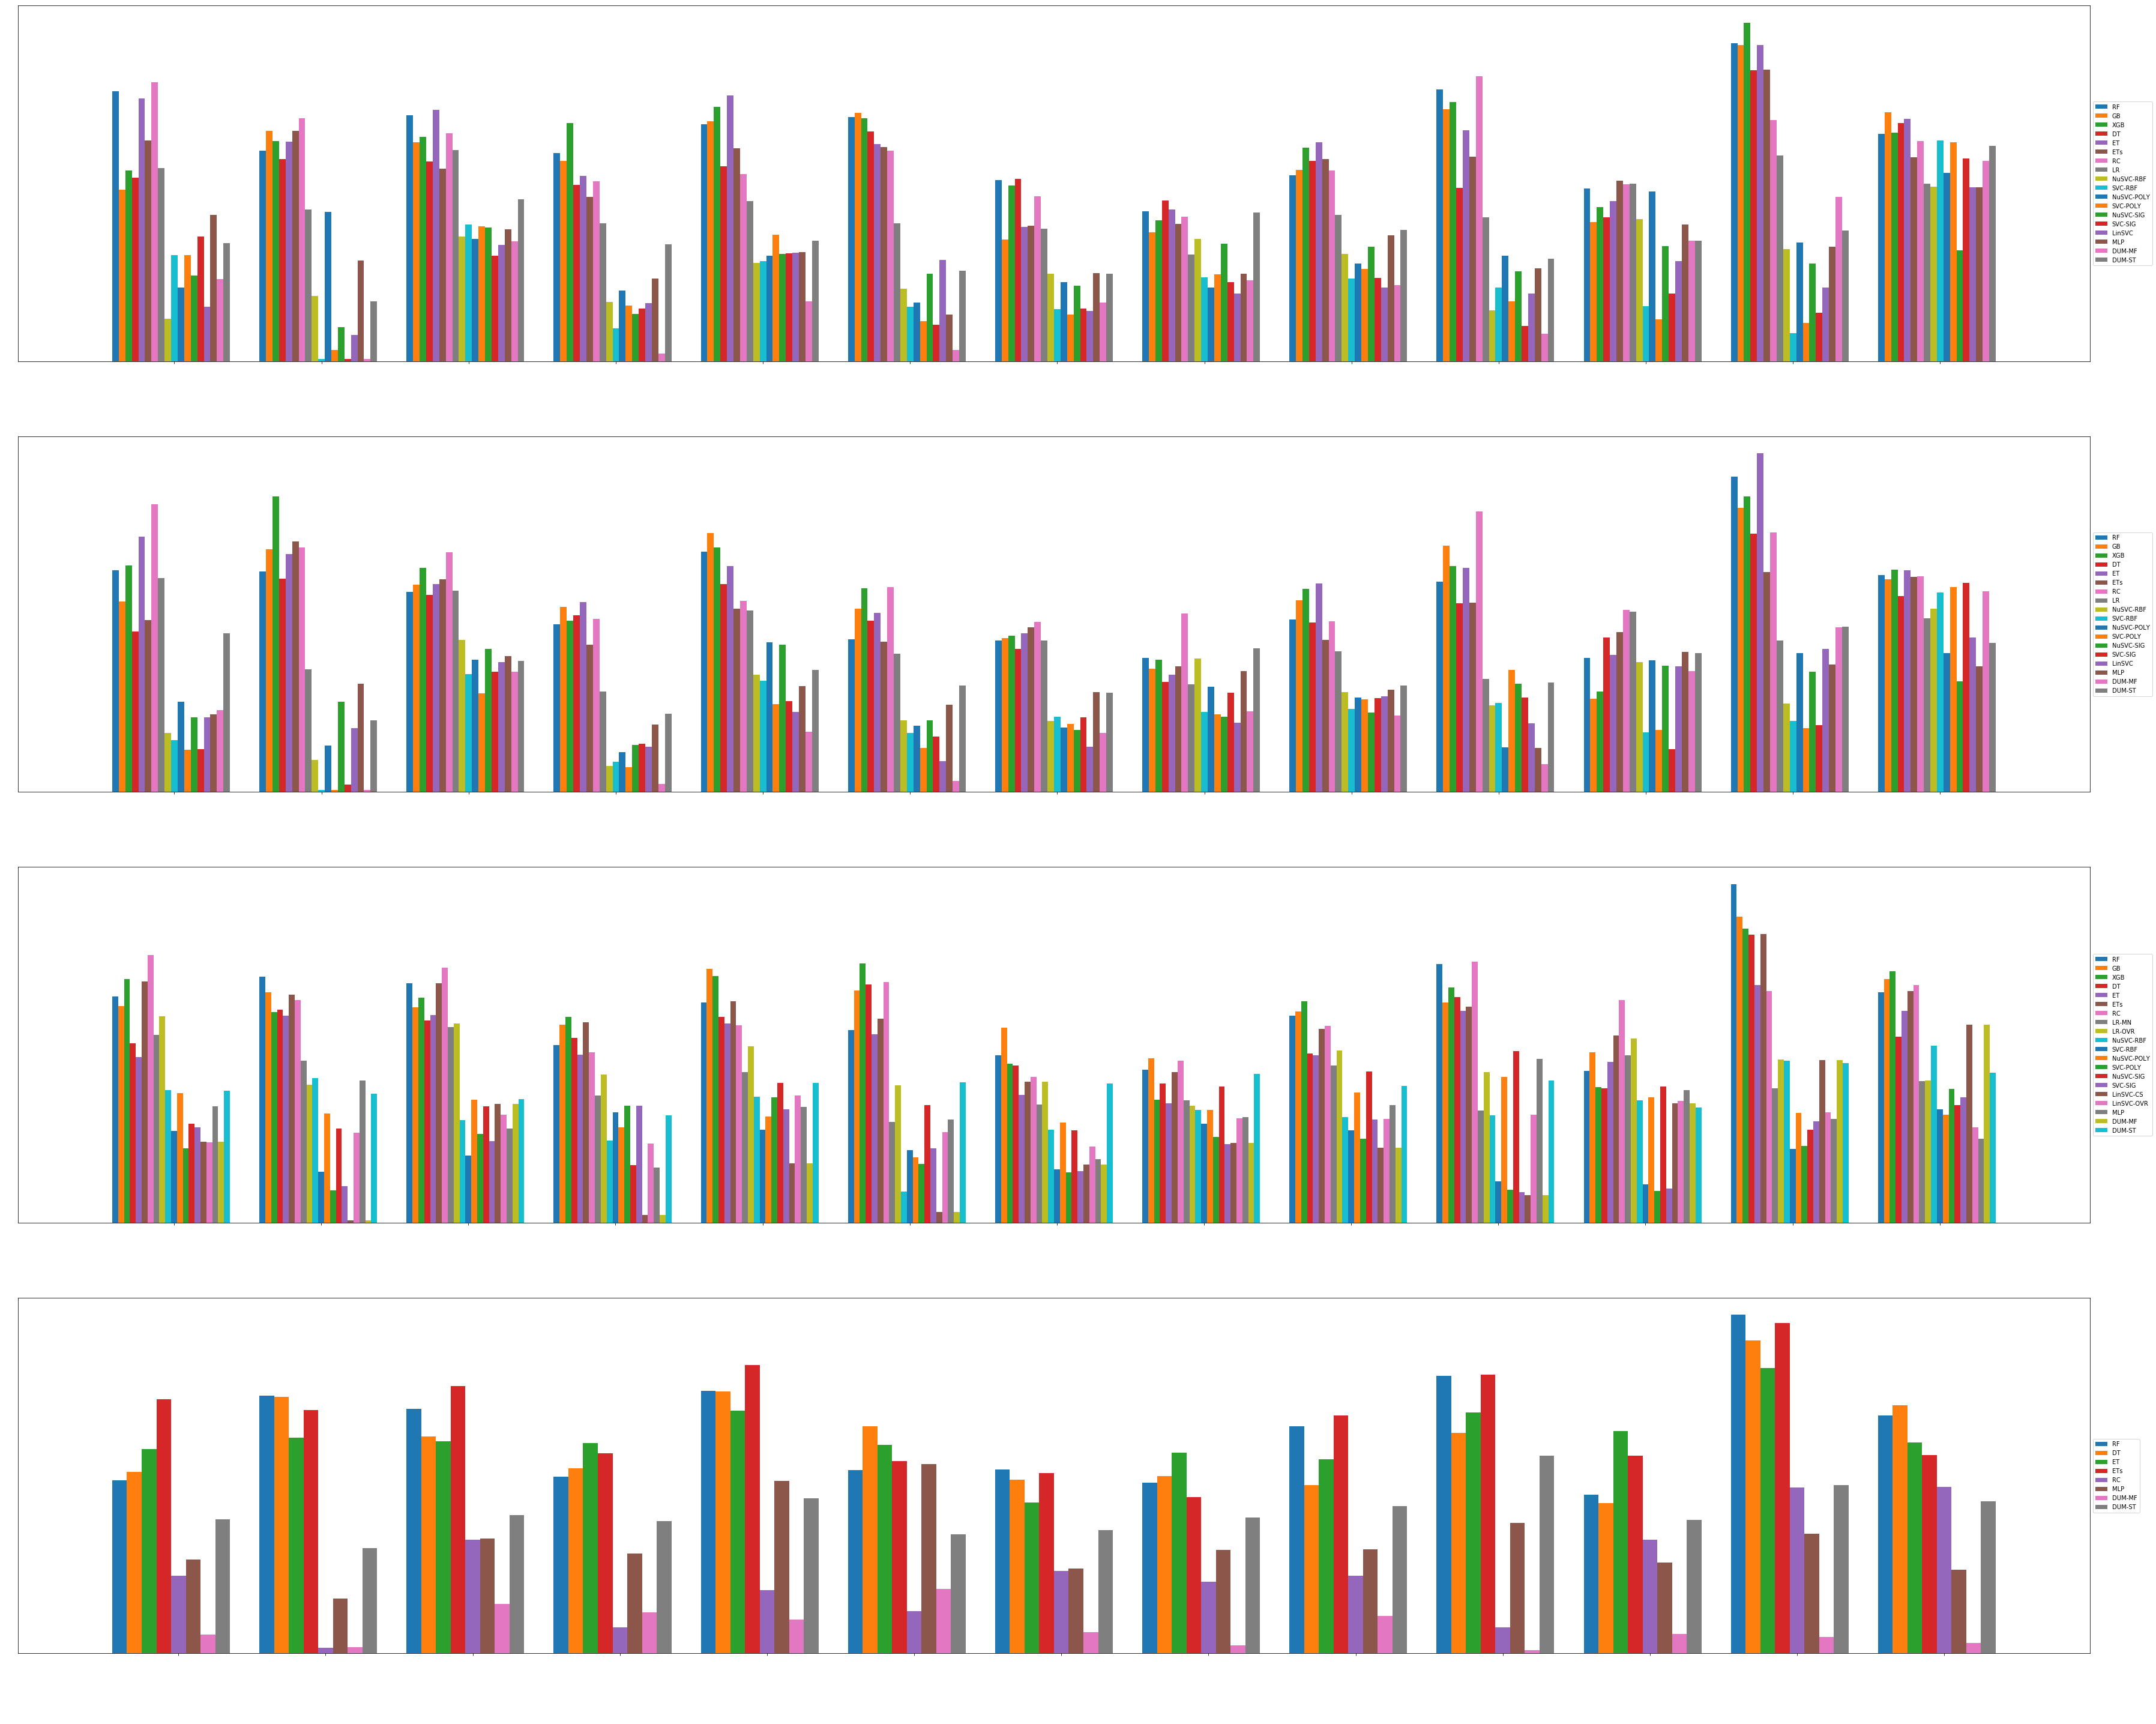

In [27]:
%matplotlib inline

from matplotlib import pyplot as plt

fig, axes = plt.subplots(4)

for i, model_type in enumerate(PRELIMINARY_CV.loc[:, 'model_type'].unique()):
    model_type_data = PRELIMINARY_CV.loc[lambda x: x['model_type'] == model_type, :]
    
    emails = model_type_data.loc[:, 'email'].unique()
    model_names = model_type_data.loc[:, 'name'].unique()
    
    x_axis = np.arange(len(emails))
    total_width = 0.8
    n_models = len(model_names)
    
    each_width = total_width / n_models
        
    for j, model_name in enumerate(model_names):
        f1_scores = model_type_data.loc[lambda x: x['name'] == model_name, 'f1']
        axes[i].bar(x_axis - total_width / 2 + j * each_width, f1_scores, each_width, label=model_name)
    
    axes[i].set_xticks(x_axis)
    axes[i].set_xticklabels(emails, rotation=45, color='w')
    axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].tick_params(axis='y', colors='w')

fig.set_size_inches(50, 40)
fig.tight_layout()
plt.show()

### Summary
* For Case 1: Random forest, XGBoost, Extra tree, and Ridge regression show good performance.
* For Case 2: Random forest, XGBoost, Extra tree, and Ridge regression show good performance.
* For Case 3: Random forest, XGBoost, Extra trees, and Ridge regression show good performance.
* For Case 4: Random forest and Extra tress show good performance.

### Implications
* Random Forest, XGBoost, Extra tree(s) and Rigde regression will be fine-tuned.

# Parameter Tuning

## Random Forest

## XGBoost Parameters

* eta: learning rate (0.01 - 0.2)
* min_child_weight

In [ ]:


ba.Wrapper(XGBClassifier()).cross_validate

### Case 1: Hierarchical model

In [ ]:
cons = 30 / 5
non_cons = 60 * 24 * 7 / 5
decay = 0.0012

(1 - 2 ** (-decay * cons)) / (1 - 2 ** (-decay) ) * (2 ** (-non_cons * decay))